In [2]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
import os

DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

In [3]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
            [0.24703223, 0.24348513, 0.26158784]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
        [0.24703223, 0.24348513, 0.26158784]),
    ]
)

train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform,download=True)

In [4]:
import torch
import torch.utils.data as data

pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

Seed set to 42


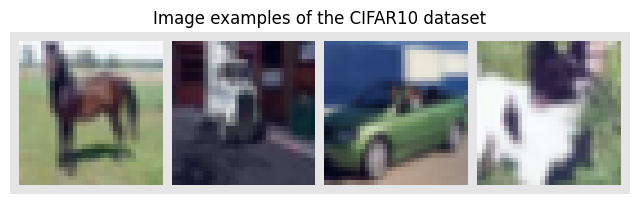

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack(
    [val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(
    CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [6]:
train_loader = data.DataLoader(
    train_set, batch_size=16,
    shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(
    val_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(
    test_set, batch_size=16,
    shuffle=False, drop_last=False, num_workers=0)

In [7]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the
            patches (integer)
        flatten_channels - If True, the patches will be
            returned in a flattened format as a feature
            vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(
        B,
        C,
        torch.div(H, patch_size, rounding_mode='trunc'),
        patch_size,
        torch.div(W, patch_size, rounding_mode='floor'),
        patch_size,
    )
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

img_patches = img_to_patch(
    CIFAR_images, patch_size=4, flatten_channels=False)

img_patches.shape

torch.Size([4, 64, 3, 4, 4])

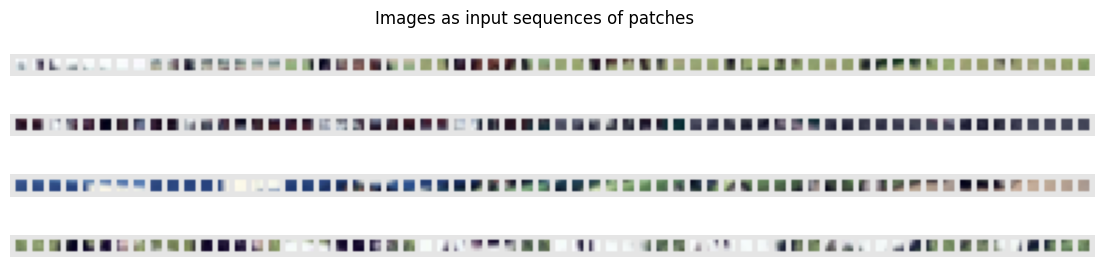

In [8]:
fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(
        img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [9]:
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [10]:
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [11]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        super().__init__()
        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(
            num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(
                embed_dim, hidden_dim, num_heads, dropout=dropout)
                    for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(
            torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [12]:
import torch.nn.functional as F
import torch.optim as optim

class ViT(pl.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss, prog_bar=True)
        self.log("%s_acc" % mode, acc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [13]:
CHECKPOINT_PATH = os.environ.get(
    "PATH_CHECKPOINT",
    "saved_models/VisionTransformers/")

def train_model(**kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        fast_dev_run=5,
    )

    pl.seed_everything(42)  # To be reproducible
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    test_result = trainer.test(
        model, dataloaders=test_loader, verbose=False)
    return model, test_result

In [14]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 4,
        "num_channels": 3,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("Results", results)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/samarthzalte/miniconda3/envs/env/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 5 batch(es). Logging and checkpointing is suppressed.
Seed set to 42

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | train
-------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
/Users/samarthzalte/miniconda3/envs/env/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Results [{'test_loss': 2.3835947513580322, 'test_acc': 0.22499999403953552}]
